### modified from PPGtoECG_4_optimized2; results as Model_BMI_Regression_FineTuning

# import packages and connect to google drive

In [ ]:
# import the right packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import einops as eo # Added
import pathlib as pl # Added
import seaborn as sns

from mat73 import loadmat
import gc

from torch.utils.data import ConcatDataset

import wfdb
import ast
import pickle
import gzip
import random
import urllib.request
import shutil
import ast
from multiprocessing import Pool, cpu_count
# from tqdm import tqdm # Removed redundant import
import os
import itertools
import matplotlib.pyplot as plt
import matplotlib
import gdown
import json
from collections import defaultdict

import matplotlib.cm as cm
from matplotlib import collections  as mc
from matplotlib import animation

%matplotlib inline

from scipy.stats import norm
from scipy.stats import entropy
from scipy.ndimage import uniform_filter1d
from scipy.stats import pearsonr

import scipy.io as sio

from datetime import datetime

#transformer:
from transformers import AutoTokenizer, AutoModel



from PIL import Image
from time import time as timer
import umap

from IPython.display import HTML
from IPython.display import Audio
import IPython

from functools import partial
from collections import Counter

from tqdm.auto import tqdm # Corrected import to get the callable tqdm function

import torch
from torchvision import datasets, transforms
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn.functional as F

import traceback


import sys
#is_colab = 'google.colab' in sys.modules

# from google.colab import drive
# drive.mount('/content/drive')

# IMPORT MLFLOW
import mlflow
from mlflow.tracking import MlflowClient


from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.model_selection import StratifiedShuffleSplit

import glob
import vitaldb

import traceback






# Load data

https://github.com/pulselabteam/PulseDB

https://www.frontiersin.org/journals/digital-health/articles/10.3389/fdgth.2022.1090854/full

In [ ]:
# extract ecg and ppg data and save into.npy which are really lighter to work with: import numpy as np

# ==========================================
# CONFIGURATION
# ==========================================

data_dir = r'C:\Users\CO\Documents\CAS_AML\Final_Project\Vital\Windowed_synchro'  # Ensure this points to your LOCAL cache
batch_files = sorted(glob.glob(os.path.join(data_dir, 'PulseDB_Vital_Batch_*_Windowed_Synch.npz')))

print(f"Converting {len(batch_files)} files to .npy for efficient memmap...")

for f_path in tqdm(batch_files):
    # Define output paths for PPG and ECG separately
    # Example: batch_01.npz -> batch_01_ppg.npy AND batch_01_ecg.npy
    ppg_npy_path = f_path.replace('.npz', '_ppg.npy')
    ecg_npy_path = f_path.replace('.npz', '_ecg.npy')
    
    # Skip if both already exist
    if os.path.exists(ppg_npy_path) and os.path.exists(ecg_npy_path):
        continue
        
    try:
        # Load the original NPZ
        with np.load(f_path) as data:
            # 1. Save PPG
            if not os.path.exists(ppg_npy_path):
                ppg_windows = data['PPG_Windows'].astype(np.float32)
                np.save(ppg_npy_path, ppg_windows)
            
            # 2. Save ECG
            if not os.path.exists(ecg_npy_path):
                ecg_windows = data['ECG_Windows'].astype(np.float32)
                np.save(ecg_npy_path, ecg_windows)
            
    except Exception as e:
        print(f"Error converting {f_path}: {e}")

print("✅ Conversion complete: Created separate _ppg.npy and _ecg.npy files.")


# Model 1: training simplified SPA AE and then attaching a regression head

### Module 1: dataloading and splitting with improve dataloader for faster computation

In [ ]:
# new from regressor2
class PPG2ECGDataset(Dataset):
    def __init__(self, data_dir, limit_files=None):
        self.ppg_files = sorted(glob.glob(os.path.join(data_dir, '*_ppg.npy')))
        self.ecg_files = sorted(glob.glob(os.path.join(data_dir, '*_ecg.npy')))
        if limit_files:
            self.ppg_files, self.ecg_files = self.ppg_files[:limit_files], self.ecg_files[:limit_files]

        total_samples = sum(np.load(f, mmap_mode='r').shape[0] for f in self.ppg_files)
        
        # Pre-allocate RAM
        self.data_ppg = np.zeros((total_samples, 1, 500), dtype=np.float32)
        self.data_ecg = np.zeros((total_samples, 1, 500), dtype=np.float32)
        self.subject_ids = np.empty(total_samples, dtype=object)
        self.bmi_values = np.zeros(total_samples, dtype=np.float32) # For Regression
        self.bmi_labels = np.zeros(total_samples, dtype=np.int8)    # For Stratification

        curr_idx = 0
        for f_ppg, f_ecg in zip(tqdm(self.ppg_files, desc="RAM Load"), self.ecg_files):
            p, e = np.load(f_ppg), np.load(f_ecg)
            n = p.shape[0]
            
            npz_path = f_ppg.replace('_ppg.npy', '.npz')
            with np.load(npz_path, allow_pickle=True) as meta:
                # Column 4: continuous BMI, Column 5: BMI category code
                demo = meta['Demographics']
                self.subject_ids[curr_idx:curr_idx+n] = meta['SubjectIDs']
                self.bmi_values[curr_idx:curr_idx+n] = demo[:, 4].astype(np.float32)
                self.bmi_labels[curr_idx:curr_idx+n] = demo[:, 5].astype(np.int8)

            self.data_ppg[curr_idx:curr_idx+n] = p.reshape(-1, 1, 500)
            self.data_ecg[curr_idx:curr_idx+n] = e.reshape(-1, 1, 500)
            curr_idx += n

    def __len__(self): return len(self.data_ppg)
    def __getitem__(self, idx):
        return (torch.from_numpy(self.data_ppg[idx].copy()), 
                torch.from_numpy(self.data_ecg[idx].copy()), 
                torch.tensor(self.bmi_values[idx], dtype=torch.float32))

In [ ]:
def create_random_stratified_splits(dataset, test_size=0.2, random_state=42):
    """
    Window-level random split stratified by BMI Category.
    Treats every window as independent to maximize shuffling [memory:1].
    """
    print(f"🏗️ Building window-level stratified splits...")
    indices = np.arange(len(dataset))
    labels = np.array(dataset.bmi_labels)
    
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_idx, val_idx = next(splitter.split(indices, labels))
    
    train_indices = indices[train_idx]
    val_indices = indices[val_idx]
    
    # Shuffle for training
    np.random.shuffle(train_indices)
    
    print(f"✅ Split Summary: Train: {len(train_indices):,} | Val: {len(val_indices):,}")
    return Subset(dataset, train_indices), Subset(dataset, val_indices)

### Module 2: WINDOW ATTENTION 

In [ ]:
class WindowAttention1D(nn.Module):
    """
    Window-based multi-head self-attention for 1D signals

    What it does:
    - Computes attention only within local windows (not globally)
    - Uses relative position bias (learned) instead of absolute positions
    - Enables efficient computation on long sequences

    Dimensions:
    Input: (batch_of_windows, window_size, dim)
    Output: (batch_of_windows, window_size, dim) - SAME SHAPE
    """
    def __init__(self, dim, window_size, num_heads):
        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        # Relative position bias table
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size - 1), num_heads)
        )

        # Generate relative position indices
        coords = torch.arange(window_size)
        relative_coords = coords[:, None] - coords[None, :]
        relative_coords += window_size - 1
        self.register_buffer("relative_position_index", relative_coords)

        # Q, K, V projections
        self.qkv = nn.Linear(dim, dim * 3)
        self.proj = nn.Linear(dim, dim)
        self.softmax = nn.Softmax(dim=-1)

        nn.init.trunc_normal_(self.relative_position_bias_table, std=.02)

    def forward(self, x, mask=None):
        B_, N, C = x.shape  # B_=batch_of_windows, N=window_size, C=dim

        # Generate Q, K, V
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        # Scaled dot-product attention
        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        # Add relative position bias
        relative_position_bias = self.relative_position_bias_table[
            self.relative_position_index.view(-1)
        ].view(self.window_size, self.window_size, -1)
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            attn = attn + mask.unsqueeze(1).unsqueeze(0)

        attn = self.softmax(attn)
        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)

        return x  # Same shape as input


### Module 3: SWIN TRANSFORMER BLOCK (optimzed for efficiency)

In [ ]:
class SwinTransformerBlock1D(nn.Module):
    """
    Swin Transformer Block with shifted window mechanism

    What it does:
    - Applies layer normalization
    - Partitions sequence into windows
    - Shifts windows (if shift_size > 0) for cross-window connections
    - Applies window attention
    - Applies MLP with GELU activation
    - Uses residual connections (Add & Norm)

    Dimensions:
    Input: (B, L, C) where L=sequence_length, C=channels
    Output: (B, L, C) - SAME SHAPE

    Key: sequence length L must be divisible by window_size
    """
    def __init__(self, dim, num_heads, window_size, shift_size=0, mlp_ratio=4.0, dropout=0.0):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio

        # Layer normalization before attention
        self.norm1 = nn.LayerNorm(dim)
        self.attn = WindowAttention1D(dim, window_size, num_heads)

        # Layer normalization before MLP
        self.norm2 = nn.LayerNorm(dim)

        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        B, L, C = x.shape
        shortcut = x
        x = self.norm1(x)

        # Shifted window mechanism
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=-self.shift_size, dims=1)
        else:
            shifted_x = x

        # Partition into windows
        num_windows = L // self.window_size
        x_windows = shifted_x.view(B, num_windows, self.window_size, C)
        x_windows = x_windows.view(B * num_windows, self.window_size, C)

        # Window attention
        attn_windows = self.attn(x_windows)

        # Merge windows back
        attn_windows = attn_windows.view(B, num_windows, self.window_size, C)
        shifted_x = attn_windows.view(B, L, C)

        # Reverse shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=self.shift_size, dims=1)
        else:
            x = shifted_x

        # Add residual connection
        x = shortcut + x

        # MLP with residual connection
        x = x + self.mlp(self.norm2(x))

        return x  # Same shape as input


### Module 4: SIMPLIFIED SPA stage

In [ ]:
class SimplifiedSPAStage(nn.Module):
    """
    Simplified SPA Stage 
    Dimensions:
    Input: (B, L, dim) e.g., (32, 500, 96)
    Output: (B, L, dim) - EXACTLY SAME SHAPE
    """
    def __init__(self, dim, depth, num_heads, window_size):
        super().__init__()
        self.dim = dim
        self.depth = depth
        self.window_size = window_size

        # Stack multiple Swin blocks with alternating shifted windows
        self.blocks = nn.ModuleList([
            SwinTransformerBlock1D(
                dim=dim,
                num_heads=num_heads,
                window_size=window_size,
                shift_size=0 if (i % 2 == 0) else window_size // 2
            )
            for i in range(depth)
        ])

    def forward(self, x):
        """
        Forward pass through all blocks
        Input shape: (B, L, dim)
        Output shape: (B, L, dim) - NO CHANGE
        """
        for blk in self.blocks:
            x = blk(x)
        return x


### Module 5: COMPLETE SIMPLIFIED SPA encoder decoder

In [ ]:
class SPAEncoderDecoderWithBMI(nn.Module):
    """
    Joint model for ECG reconstruction and BMI regression.
    """
    def __init__(self, in_channels=1, out_channels=1, embed_dim=96, num_heads=8, mlp_hidden_dim=64):
        super().__init__()

        # --- Autoencoder Backbone ---
        self.input_proj = nn.Sequential(
            nn.Conv1d(in_channels, embed_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(embed_dim), nn.GELU())

        self.encoder_stages = nn.ModuleList([
            SimplifiedSPAStage(dim=embed_dim, depth=2, num_heads=num_heads, window_size=125),
            SimplifiedSPAStage(dim=embed_dim, depth=2, num_heads=num_heads, window_size=100),
            SimplifiedSPAStage(dim=embed_dim, depth=6, num_heads=num_heads, window_size=50),
            SimplifiedSPAStage(dim=embed_dim, depth=6, num_heads=num_heads, window_size=25),
            SimplifiedSPAStage(dim=embed_dim, depth=2, num_heads=num_heads, window_size=10)])
        


        self.decoder_stages = nn.ModuleList([
            SimplifiedSPAStage(dim=embed_dim, depth=2, num_heads=num_heads, window_size=10),
            SimplifiedSPAStage(dim=embed_dim, depth=6, num_heads=num_heads, window_size=25),
            SimplifiedSPAStage(dim=embed_dim, depth=6, num_heads=num_heads, window_size=50),
            SimplifiedSPAStage(dim=embed_dim, depth=2, num_heads=num_heads, window_size=100),
            SimplifiedSPAStage(dim=embed_dim, depth=2, num_heads=num_heads, window_size=125)])

        self.skip_connections = nn.ModuleList([nn.Identity() for _ in range(5)])

        self.output_proj = nn.Sequential(
            nn.Conv1d(embed_dim, embed_dim // 2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(embed_dim // 2), nn.GELU(),
            nn.Conv1d(embed_dim // 2, out_channels, kernel_size=3, stride=1, padding=1))

        # --- BMI Regression Head (1-layer MLP) ---
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.bmi_head = nn.Sequential(
            nn.Linear(embed_dim, mlp_hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(mlp_hidden_dim, 1) # Output 1 continuous value
        )

    def forward(self, x):
        # Encoder
        x = self.input_proj(x).transpose(1, 2)
        encoder_features_list = []
        for stage in self.encoder_stages:
            x = stage(x)
            encoder_features_list.append(x)
        
        latent_features = x 

        # Decoder (for Reconstruction)
        dec_features = latent_features
        for i, stage in enumerate(self.decoder_stages):
            skip_feature = encoder_features_list[len(encoder_features_list) - 1 - i]
            dec_features = dec_features + self.skip_connections[i](skip_feature)
            dec_features = stage(dec_features)
        
        recon_ecg = self.output_proj(dec_features.transpose(1, 2))

        # BMI Head
        pooled_features = self.global_pool(latent_features.transpose(1, 2)).squeeze(-1)
        bmi_pred = self.bmi_head(pooled_features)

        return recon_ecg, bmi_pred.squeeze(-1)

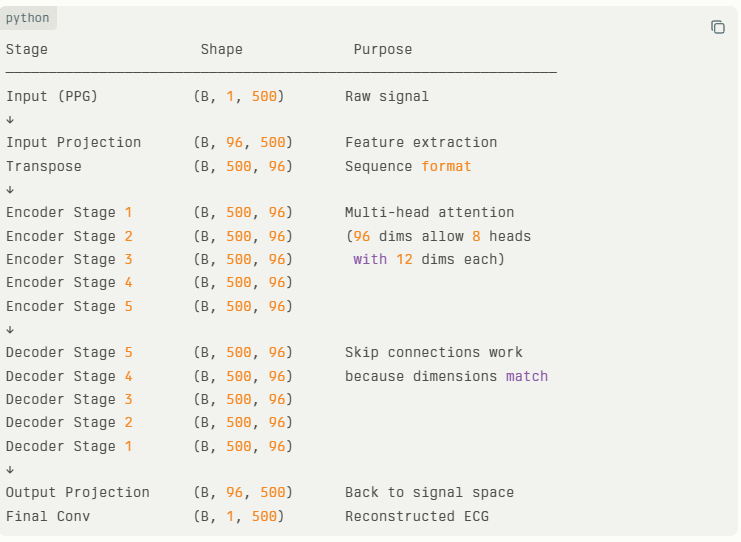

### Module 7: train and save the simplified SPA AE

In [ ]:
# New tracking URI and experiment for the Autoencoder-only run
mlflow.set_tracking_uri(r"sqlite:///C:/Users/CO/Documents/CAS_AML/Final_Project/mlruns_db/mlflow.db")
mlflow.set_experiment("AE_ONLY_PPG-ECG_RandomSplit")


if __name__ == "__main__":
    # --- CONFIGURATION ---
    windowed_dir = r'C:\Users\CO\Documents\CAS_AML\Final_Project\Vital\Windowed_synchro'
    save_dir = r'C:\Users\CO\Documents\CAS_AML\Final_Project\Results\Model_AE_Only_RandomSplit'
    
    # RTX 4060 Tuning: 8GB VRAM limit requires slightly smaller batches than high-end cards [web:6][web:9].
    # num_workers=0 is used to avoid Windows-specific multiprocessing overhead [web:7].
    BATCH_SIZE = 48  
    NUM_EPOCHS = 10
    LEARNING_RATE = 0.0001
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    CHECKPOINT_PATH = os.path.join(save_dir, 'checkpoint_ae_last.pth')
    BEST_MODEL_PATH = os.path.join(save_dir, 'best_ae_model.pth')
    SAVE_EVERY_N_BATCHES = 1500 

    os.makedirs(save_dir, exist_ok=True)
    
    with mlflow.start_run(run_name="AE_Reconstruction_Only") as run:
        mlflow.log_params({"batch_size": BATCH_SIZE, "model": "AE_Only", "device": "RTX_4060"})

        try:
            # 1. DATA PREPARATION
            full_dataset = PPG2ECGDataset(windowed_dir)
            train_ds, val_ds = create_random_stratified_splits(full_dataset)
            
            # pin_memory=True speeds up transfer to GPU [web:5].
            train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
            val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

            # 2. INITIALIZATION (Assuming SPAEncoderDecoder exists without BMI head)
            # If your model still has the head, we ignore the second output.
            model = SPAEncoderDecoderWithBMI(embed_dim=96, num_heads=8).to(DEVICE)
            optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
            scaler = torch.amp.GradScaler(enabled=(DEVICE == 'cuda'))
            
            recon_criterion = nn.MSELoss()

            # 3. RESUME LOGIC
            start_epoch, start_batch, best_val_loss = 0, 0, float('inf')
            history = {'train_loss':[], 'val_loss':[]}

            if os.path.exists(CHECKPOINT_PATH):
                checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                start_epoch = checkpoint['epoch']
                best_val_loss = checkpoint.get('best_val_loss', float('inf'))
                print(f"🔄 Resumed at Epoch {start_epoch+1}")

            # 4. TRAINING LOOP
            for epoch in range(start_epoch, NUM_EPOCHS):
                model.train()
                t_loss = 0
                pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}")
                
                for batch_idx, (ppg, ecg, _) in pbar:
                    ppg, ecg = ppg.to(DEVICE), ecg.to(DEVICE)
                    
                    optimizer.zero_grad()
                    with torch.amp.autocast('cuda'):
                        # Ignore the BMI prediction head output (_)
                        recon, _ = model(ppg)
                        loss = recon_criterion(recon, ecg)
                    
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                    
                    t_loss += loss.item()

                    if batch_idx % SAVE_EVERY_N_BATCHES == 0 and batch_idx > 0:
                        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(),
                                    'optimizer_state_dict': optimizer.state_dict(),
                                    'best_val_loss': best_val_loss}, CHECKPOINT_PATH)

                # 5. VALIDATION
                model.eval()
                v_loss = 0
                with torch.no_grad():
                    for ppg, ecg, _ in tqdm(val_loader, desc="Val"):
                        ppg, ecg = ppg.to(DEVICE), ecg.to(DEVICE)
                        with torch.amp.autocast('cuda'):
                            recon, _ = model(ppg)
                            loss = recon_criterion(recon, ecg)
                        v_loss += loss.item()

                # LOGGING
                avg_train_loss = t_loss / len(train_loader)
                avg_val_loss = v_loss / len(val_loader)
                
                mlflow.log_metrics({"train_loss": avg_train_loss, "val_loss": avg_val_loss}, step=epoch+1)
                print(f"Epoch {epoch+1} Summary: Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")
                
                scheduler.step(avg_val_loss)
                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss
                    torch.save(model.state_dict(), BEST_MODEL_PATH)
                    print(f"  ⭐ New Best Val Loss: {best_val_loss:.6f}")

        except Exception as e:
            traceback.print_exc()
        finally:
            if torch.cuda.is_available(): 
                torch.cuda.empty_cache()


need to install a torch that is compatible and optimized for RTX 4060's sm_89. run this code in BASH: pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
Looking in indexes: https://download.pytorch.org/whl/cu124  (in myenv, and after removing the old torch version)

In [ ]:
import torch
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"Device Name: {torch.cuda.get_device_name(0)}")
print(f"Compute Capability: {torch.cuda.get_device_capability(0)}")


## retrieving data from mlflow to plot the train and val loss

In [ ]:
# 1. Connect to your local DB
mlflow.set_tracking_uri(r"sqlite:///C:/Users/CO/Documents/CAS_AML/Final_Project/mlruns_db/mlflow.db")
client = MlflowClient()

# 2. Get the experiment and run
exp = client.get_experiment_by_name("AE_ONLY_PPG-ECG_RandomSplit")
runs = client.search_runs(exp.experiment_id, order_by=["attribute.start_time DESC"], max_results=1)
latest_run_id = runs[0].info.run_id

# 3. Fetch metrics
train_loss_history = client.get_metric_history(latest_run_id, "train_loss")
val_loss_history = client.get_metric_history(latest_run_id, "val_loss")

# 4. Process Data
df = pd.DataFrame({
    'epoch': [m.step for m in train_loss_history],
    'train_loss': [m.value for m in train_loss_history],
    'val_loss': [m.value for m in val_loss_history]
})

# Calculate the difference (Train - Val)
df['loss_diff'] = df['train_loss'] - df['val_loss']

# 5. Plotting Side-by-Side
# figsize=(width, height) - increased width to accommodate two plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6)) 

# --- LEFT PLOT: Absolute Loss Curves ---
axes[0].plot(df['epoch'], df['train_loss'], label='Train Loss', marker='o', markersize=3)
axes[0].plot(df['epoch'], df['val_loss'], label='Val Loss', marker='o', markersize=3)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].legend()
axes[0].set_title('Autoencoder Reconstruction Loss')
axes[0].grid(True, alpha=0.3)

# --- RIGHT PLOT: Difference (Train - Val) ---
axes[1].plot(df['epoch'], df['loss_diff'], color='purple', label='Train - Val', marker='x')
axes[1].axhline(0, color='black', linestyle='--', linewidth=1.5, label='Zero Line') # Reference line
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Difference value')
axes[1].legend()
axes[1].set_title('Generalization Gap (Train Loss - Val Loss)')
axes[1].grid(True, alpha=0.3)

# Adjust layout to prevent overlapping labels
plt.tight_layout()
plt.show()


# Building BMI head

##  using a subject level stratified shuffling

In [ ]:
def create_subject_level_stratified_splits(dataset, test_size=0.2, random_state=42):
    """
    Subject-level split stratified by BMI Category.
    Ensures no subject leakage while maintaining BMI distribution.
    """
    print(f"🏗️ Building subject-to-indices mapping from RAM...")
    
    # 1. Map every window to its subject and BMI Category
    subject_to_indices = defaultdict(list)
    subject_to_bmi_cat = {}
    
    # Efficiently iterate through RAM-resident metadata
    for idx, subj_id in enumerate(dataset.subject_ids):
        subject_to_indices[subj_id].append(idx)
        # Only need to store the category code once per subject
        if subj_id not in subject_to_bmi_cat:
            subject_to_bmi_cat[subj_id] = dataset.bmi_labels[idx]

    # 2. Prepare Unique Subjects and their corresponding BMI Categories
    unique_subjects = np.array(sorted(list(subject_to_indices.keys())))
    subject_stratify_labels = np.array([subject_to_bmi_cat[s] for s in unique_subjects])
    
    # 3. Perform Stratified Subject-Level Split
    # This ensures BMI categories are balanced across Train and Val
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_subj_idx, val_subj_idx = next(splitter.split(unique_subjects, subject_stratify_labels))
    
    train_subjects = unique_subjects[train_subj_idx]
    val_subjects = unique_subjects[val_subj_idx]
    
    # 4. Convert Subject IDs back to Global Window Indices
    train_indices = []
    for s in train_subjects:
        train_indices.extend(subject_to_indices[s])
        
    val_indices = []
    for s in val_subjects:
        val_indices.extend(subject_to_indices[s])

    # 5. Final Shuffle and Verification
    np.random.shuffle(train_indices)
    
    print(f"✅ Split Summary:")
    print(f"   Train: {len(train_subjects):>5} subjects | {len(train_indices):>10,} windows")
    print(f"   Val:   {len(val_subjects):>5} subjects | {len(val_indices):>10,} windows")
    
    # Verification of no leakage
    assert set(train_subjects).isdisjoint(set(val_subjects)), "❌ ALERT: Subject leakage detected!"
    
    return Subset(dataset, train_indices), Subset(dataset, val_indices)


In [ ]:
# --- PLOTTING UTILS ---
def save_plots(history, val_true, val_pred, save_dir):
    """Generates and saves the requested analysis plots."""
    epochs = range(1, len(history['train_loss']) + 1)
    
    # 1. Loss Curves
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history['train_loss'], label='Train Loss (MSE)')
    plt.plot(epochs, history['val_loss'], label='Val Loss (MSE)')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(save_dir, 'loss_curves.png'))
    plt.close()

    # 2. Delta Loss (Train - Val)
    delta_loss = np.array(history['train_loss']) - np.array(history['val_loss'])
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, delta_loss, label='Delta (Train - Val)', color='purple')
    plt.axhline(0, color='black', linestyle='--')
    plt.title('Loss Difference (Train - Val)')
    plt.xlabel('Epochs')
    plt.ylabel('Difference')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(save_dir, 'loss_delta.png'))
    plt.close()

    # 3. Predicted vs True BMI
    plt.figure(figsize=(8, 8))
    plt.scatter(val_true, val_pred, alpha=0.5, s=10)
    
    # Identity line
    lims = [
        np.min([np.min(val_true), np.min(val_pred)]),
        np.max([np.max(val_true), np.max(val_pred)]),
    ]
    plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0, label="Identity Line")
    
    plt.title(f'Predicted vs True BMI\nCorrelation: {np.corrcoef(val_true, val_pred)[0,1]:.3f}')
    plt.xlabel('True BMI')
    plt.ylabel('Predicted BMI')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(save_dir, 'bmi_pred_vs_true.png'))
    plt.close()

In [ ]:
class SPAEncoderDecoderWithBMI(nn.Module):
    """
    Joint model for ECG reconstruction and BMI regression.
    """
    def __init__(self, in_channels=1, out_channels=1, embed_dim=96, num_heads=8, mlp_hidden_dim=64):
        super().__init__()

        # --- Autoencoder Backbone ---
        self.input_proj = nn.Sequential(
            nn.Conv1d(in_channels, embed_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(embed_dim), nn.GELU())

        self.encoder_stages = nn.ModuleList([
            SimplifiedSPAStage(dim=embed_dim, depth=2, num_heads=num_heads, window_size=125),
            SimplifiedSPAStage(dim=embed_dim, depth=2, num_heads=num_heads, window_size=100),
            SimplifiedSPAStage(dim=embed_dim, depth=6, num_heads=num_heads, window_size=50),
            SimplifiedSPAStage(dim=embed_dim, depth=6, num_heads=num_heads, window_size=25),
            SimplifiedSPAStage(dim=embed_dim, depth=2, num_heads=num_heads, window_size=10)])
        


        self.decoder_stages = nn.ModuleList([
            SimplifiedSPAStage(dim=embed_dim, depth=2, num_heads=num_heads, window_size=10),
            SimplifiedSPAStage(dim=embed_dim, depth=6, num_heads=num_heads, window_size=25),
            SimplifiedSPAStage(dim=embed_dim, depth=6, num_heads=num_heads, window_size=50),
            SimplifiedSPAStage(dim=embed_dim, depth=2, num_heads=num_heads, window_size=100),
            SimplifiedSPAStage(dim=embed_dim, depth=2, num_heads=num_heads, window_size=125)])

        self.skip_connections = nn.ModuleList([nn.Identity() for _ in range(5)])

        self.output_proj = nn.Sequential(
            nn.Conv1d(embed_dim, embed_dim // 2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(embed_dim // 2), nn.GELU(),
            nn.Conv1d(embed_dim // 2, out_channels, kernel_size=3, stride=1, padding=1))

        # --- BMI Regression Head (1-layer MLP) ---
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.bmi_head = nn.Sequential(
            nn.Linear(embed_dim, mlp_hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(mlp_hidden_dim, 1) # Output 1 continuous value
        )

   
    def forward(self, x, skip_decoder=False):
        # --- Encoder (Always runs) ---
        x = self.input_proj(x).transpose(1, 2)
        encoder_features_list = []
        for stage in self.encoder_stages:
            x = stage(x)
            encoder_features_list.append(x)
        
        latent_features = x 

        # --- BMI Head (Always runs) ---
        # We process this NOW so we can return early if needed
        pooled_features = self.global_pool(latent_features.transpose(1, 2)).squeeze(-1)
        bmi_pred = self.bmi_head(pooled_features)

        # --- Optimization: Skip Decoder ---
        if skip_decoder:
            # Return None for reconstruction to save massive compute
            return None, bmi_pred.squeeze(-1)

        # --- Decoder (Only runs if skip_decoder=False) ---
        dec_features = latent_features
        for i, stage in enumerate(self.decoder_stages):
            skip_feature = encoder_features_list[len(encoder_features_list) - 1 - i]
            dec_features = dec_features + self.skip_connections[i](skip_feature)
            dec_features = stage(dec_features)
        
        recon_ecg = self.output_proj(dec_features.transpose(1, 2))

        return recon_ecg, bmi_pred.squeeze(-1)


In [ ]:
# BMI head

# --- CONFIGURATION ---
mlflow.set_tracking_uri(r"sqlite:///C:/Users/CO/Documents/CAS_AML/Final_Project/mlruns_db/mlflow.db")
mlflow.set_experiment("BMI_Regression_FineTuning")

if __name__ == "__main__":
    # Directories
    windowed_dir = r'C:\Users\CO\Documents\CAS_AML\Final_Project\Vital\Windowed_synchro'
    # Path to the AE model trained in the PREVIOUS step
    pretrained_ae_path = r'C:\Users\CO\Documents\CAS_AML\Final_Project\Results\Model_AE_Only_RandomSplit\best_ae_model.pth'
    # New save directory for this regression run
    save_dir = r'C:\Users\CO\Documents\CAS_AML\Final_Project\Results\Model_BMI_Regression_FineTuning'
    
    # Hyperparameters
    BATCH_SIZE = 48
    NUM_EPOCHS = 10
    LEARNING_RATE = 0.0001
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    CHECKPOINT_PATH = os.path.join(save_dir, 'checkpoint_bmi_last.pth')
    BEST_MODEL_PATH = os.path.join(save_dir, 'best_bmi_model.pth')
    SAVE_EVERY_N_BATCHES = 1500 

    os.makedirs(save_dir, exist_ok=True)
    
    with mlflow.start_run(run_name="BMI_Transfer_Learning") as run:
        mlflow.log_params({
            "batch_size": BATCH_SIZE, 
            "model": "BMI_Head_FineTune", 
            "pretrained_weights": "AE_RandomSplit",
            "splitter": "SubjectLevel"
        })

        try:
            # 1. DATA PREPARATION (Using Subject-Level Split)
            # Assuming PPG2ECGDataset is defined in your environment
            full_dataset = PPG2ECGDataset(windowed_dir) 
            
            # Use the Subject-Level Splitter here!
            train_ds, val_ds = create_subject_level_stratified_splits(full_dataset)
            
            train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
            val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

            # 2. INITIALIZATION & LOADING WEIGHTS
            # Initialize the full model structure
            model = SPAEncoderDecoderWithBMI(embed_dim=96, num_heads=8).to(DEVICE)
            
            # Load Pretrained Weights
            if os.path.exists(pretrained_ae_path):
                print(f"🔄 Loading pre-trained AE weights from: {pretrained_ae_path}")
                pretrained_dict = torch.load(pretrained_ae_path, map_location=DEVICE)
                
                # Load weights, but strict=False in case the BMI head layers were not in the saved AE dictionary
                # If the AE was saved with the BMI head layers (even if untrained), strict=True works.
                # Using strict=False is safer for transfer learning.
                missing, unexpected = model.load_state_dict(pretrained_dict, strict=False)
                print(f"   Weights loaded. Missing keys (expected for new head): {len(missing)}")
            else:
                print("⚠️ WARNING: Pretrained model not found. Training from scratch.")

            # --- FREEZE AE LAYERS ---
            print("❄️ Freezing Encoder and Decoder layers...")
            for name, param in model.named_parameters():
                # We assume your BMI head layers have 'bmi' or 'head' in their name
                # Adjust string 'bmi' if your specific layer is named differently (e.g. 'regressor')
                if "bmi_head" in name:
                    param.requires_grad = True
                    print(f"   🔓 Unfrozen (Training): {name}")
                else:
                    param.requires_grad = False

            # Optimizer settings (Same as AE run)
            # optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
            optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                                   lr=LEARNING_RATE, weight_decay=1e-5)
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
            scaler = torch.amp.GradScaler(enabled=(DEVICE == 'cuda'))
            
            # LOSS FUNCTION: MSE for Regression; we keep MSE_loss instead as nn.L1Loss() as we want to have good prediction also for large BMI values. 
            bmi_criterion = nn.MSELoss()

            # 3. RESUME LOGIC (For this specific BMI run, not the AE run)
            start_epoch = 0
            best_val_loss = float('inf')
            history = {'train_loss':[], 'val_loss':[]}

            if os.path.exists(CHECKPOINT_PATH):
                checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                start_epoch = checkpoint['epoch'] + 1
                best_val_loss = checkpoint.get('best_val_loss', float('inf'))
                print(f"🔄 Resumed BMI Training at Epoch {start_epoch+1}")

            # 4. TRAINING LOOP
            for epoch in range(start_epoch, NUM_EPOCHS):
                model.train()
                t_loss = 0
                pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}")
                
                for batch_idx, (ppg, ecg, bmi_target) in pbar:
                    ppg = ppg.to(DEVICE)
                    # Ensure BMI target is float and correct shape (Batch, 1)
                    bmi_target = bmi_target.float().unsqueeze(1).to(DEVICE) 
                    
                    optimizer.zero_grad()
                    with torch.amp.autocast('cuda'):
                        # Now we care about the second output: bmi_pred
                        # recon is ignored or used as auxiliary loss if desired
                        recon, bmi_pred = model(ppg, skip_decoder=True)
                        loss = bmi_criterion(bmi_pred, bmi_target)
                        
                    
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                    
                    t_loss += loss.item()

                    # Save Checkpoint every N batches
                    if batch_idx % SAVE_EVERY_N_BATCHES == 0 and batch_idx > 0:
                        torch.save({
                            'epoch': epoch, 
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'best_val_loss': best_val_loss
                        }, CHECKPOINT_PATH)

                # 5. VALIDATION
                model.eval()
                v_loss = 0
                
                # Containers for plotting
                all_val_preds = []
                all_val_trues = []

                with torch.no_grad():
                    for ppg, ecg, bmi_target in tqdm(val_loader, desc="Val"):
                        ppg = ppg.to(DEVICE)
                        bmi_target = bmi_target.float().unsqueeze(1).to(DEVICE)
                        
                        with torch.amp.autocast('cuda'):
                            _, bmi_pred = model(ppg, skip_decoder=True)
                            loss = bmi_criterion(bmi_pred, bmi_target)
                        
                        v_loss += loss.item()
                        
                        # Collect data for plotting (only need to do this on the last epoch ideally, 
                        # but doing it here ensures we track the best model metrics)
                        all_val_preds.extend(bmi_pred.cpu().numpy().flatten())
                        all_val_trues.extend(bmi_target.cpu().numpy().flatten())

                # LOGGING
                avg_train_loss = t_loss / len(train_loader)
                avg_val_loss = v_loss / len(val_loader)
                
                history['train_loss'].append(avg_train_loss)
                history['val_loss'].append(avg_val_loss)
                
                mlflow.log_metrics({
                    "train_rmse": np.sqrt(avg_train_loss), 
                    "val_rmse": np.sqrt(avg_val_loss),
                    "val_loss_mse": avg_val_loss
                }, step=epoch+1)
                
                print(f"Epoch {epoch+1} | Train MSE: {avg_train_loss:.4f} | Val MSE: {avg_val_loss:.4f}")
                
                scheduler.step(avg_val_loss)
                
                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss
                    torch.save(model.state_dict(), BEST_MODEL_PATH)
                    print(f"  ⭐ New Best Val Loss: {best_val_loss:.6f}")
                    # Optional: Save 'best' predictions for plotting later
                    np.savez(os.path.join(save_dir, 'best_predictions.npz'), 
                             y_true=all_val_trues, y_pred=all_val_preds)

            # 6. PLOTTING (End of training)
            # Load best predictions for the final plot
            best_preds_data = np.load(os.path.join(save_dir, 'best_predictions.npz'))
            save_plots(history, best_preds_data['y_true'], best_preds_data['y_pred'], save_dir)
            
            # Log plots to MLflow
            mlflow.log_artifact(os.path.join(save_dir, 'loss_curves.png'))
            mlflow.log_artifact(os.path.join(save_dir, 'bmi_pred_vs_true.png'))
            print("📈 Plots generated and saved to MLflow.")

        except Exception as e:
            traceback.print_exc()
        finally:
            if torch.cuda.is_available(): 
                torch.cuda.empty_cache()
